In [26]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import time

np.seterr(divide='ignore', invalid='ignore')

#Move to parent folder
sys.path.insert(0, '../croprows-cli/src/')

In [27]:
#imgobj = cv2.imread("../orthomosaics/results/testfile3/mosaic_5_5_1077px_25_tiles/mosaic-cl_3-rw_2.jpg")
imgobj = cv2.imread("../orthomosaics/results/testfile7/mosaic_10_8_1339px_80_tiles/mosaic-cl_3-rw_2.jpg")

In [28]:
quarter = cv2.resize(imgobj, (0,0), fx=0.5, fy=0.5)

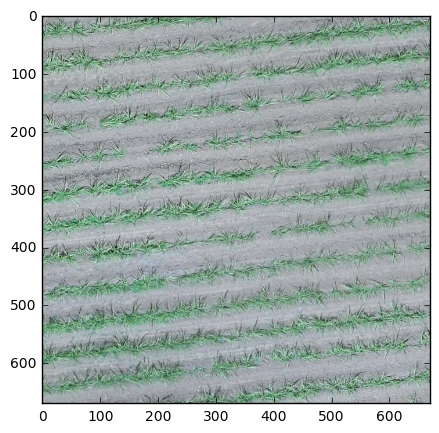

In [29]:
plt.figure(figsize=(5, 5))
plt.imshow(quarter)
plt.show()

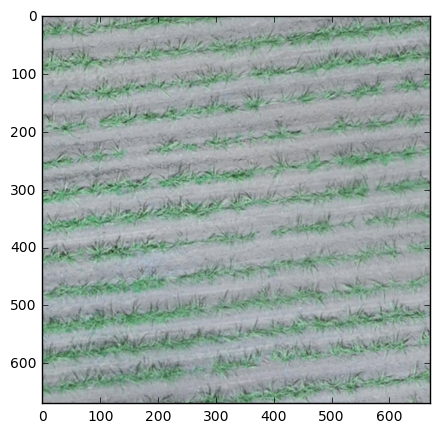

In [30]:
blur = cv2.blur(quarter,(3,3))

plt.figure(figsize=(5, 5))
plt.imshow(blur)
plt.show()

In [31]:
hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)


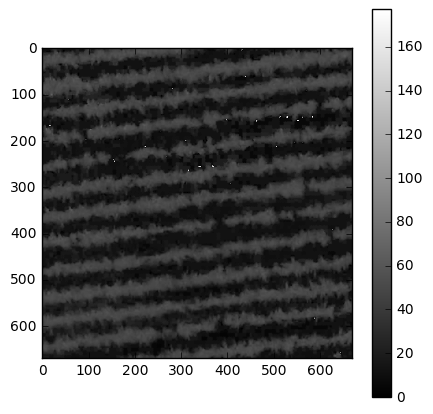

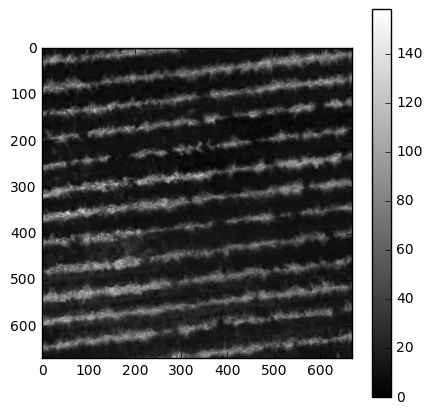

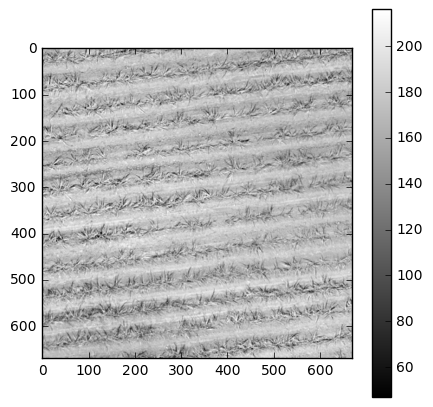

In [32]:
H, S, V = cv2.split(hsv)

plt.figure(figsize=(5, 5))
plt.imshow(H,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(S,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(V,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

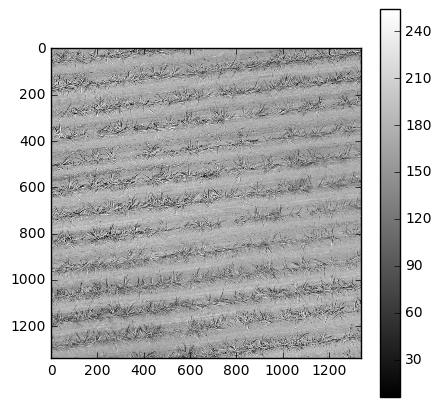

In [33]:
gray = cv2.cvtColor(imgobj, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(5, 5))
plt.imshow(gray,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

In [34]:
print('H')
print('min:'+str(np.min(H)))
print('max:'+str(np.max(H)))

print('S')
print(np.min(S))
print(np.max(S))

print('mean:'+str(np.mean(S)))
print('mean_:'+str(np.mean(S)/255))

print('V')
print(np.min(V))
print(np.max(V))

H
min:0
max:177
S
0
158
mean:27.5671998218
mean_:0.108106665968
V
47
216


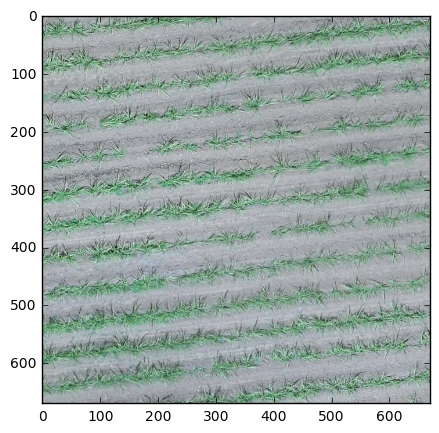

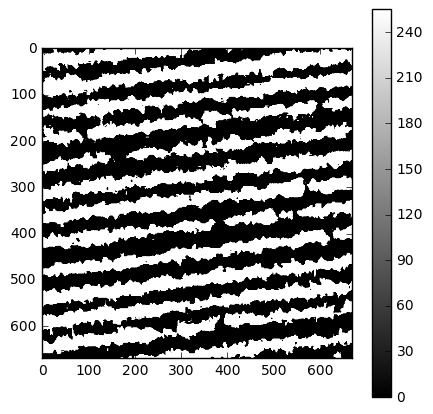

In [35]:
ret,thresh1 = cv2.threshold(H, 0, 255, cv2.THRESH_OTSU)

plt.figure(figsize=(5, 5))
plt.imshow(quarter)
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(thresh1,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

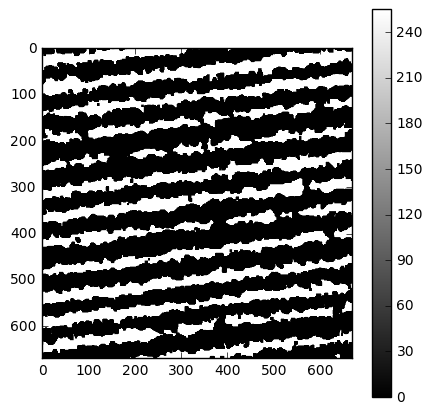

In [36]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(thresh1,kernel,iterations = 1)

plt.figure(figsize=(5, 5))
plt.imshow(erosion,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

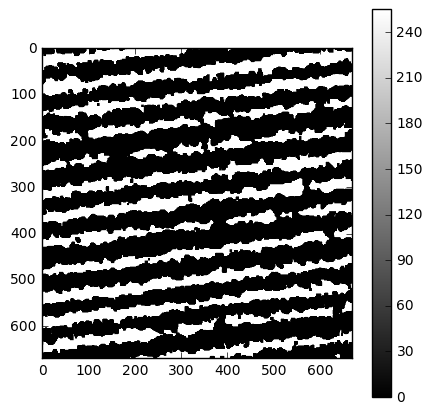

In [37]:
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(5, 5))
plt.imshow(closing,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

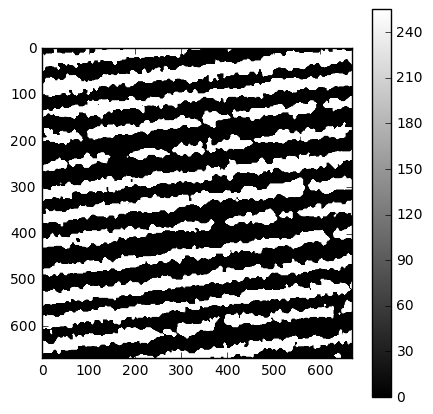

In [49]:
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)) 
dilated_2 = cv2.dilate(closing, element)

plt.figure(figsize=(5, 5))
plt.imshow(dilated_2,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

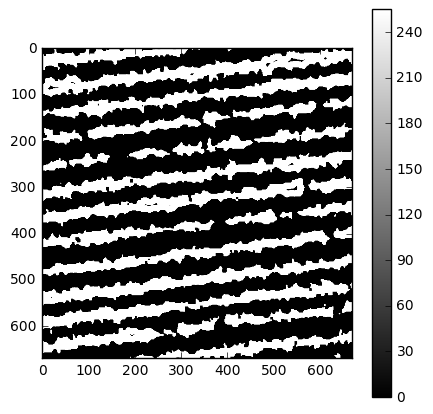

In [39]:
dist_transform = cv2.distanceTransform(dilated_2,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(dilated_2,sure_fg)

plt.figure(figsize=(5, 5))
plt.imshow(unknown,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()


In [40]:
def skeletonize(img):
    img = img.copy()
    skel = img.copy()
    skel[:,:] = 0
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]
        if cv2.countNonZero(img) == 0:
            break
    return skel

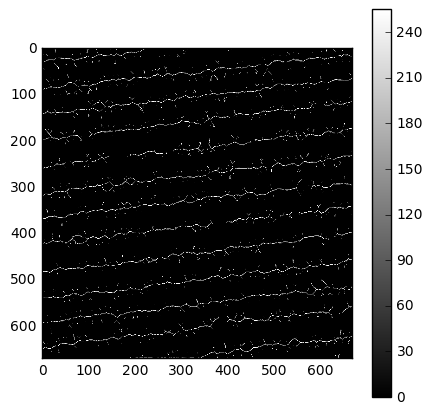

In [41]:
skel = skeletonize(closing)
plt.figure(figsize=(5, 5))
plt.imshow(skel,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

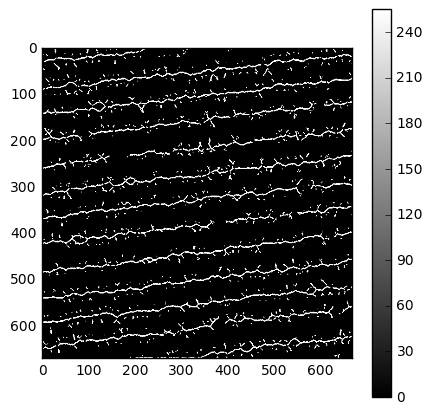

In [42]:
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)) 
dilated = cv2.dilate(skel, element)

plt.figure(figsize=(5, 5))
plt.imshow(dilated,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()



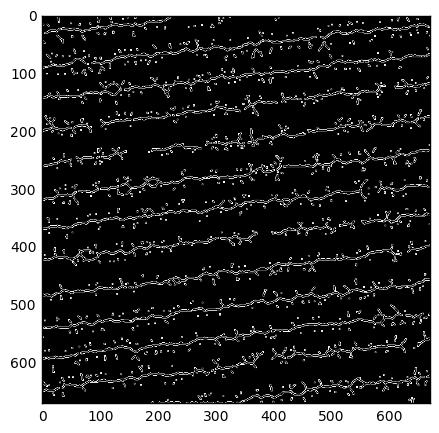

In [43]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

autocanny = auto_canny(dilated)

plt.figure(figsize=(5, 5))
plt.imshow(autocanny,cmap=plt.get_cmap('gray'))
plt.show()

In [44]:
_,contours, _ = cv2.findContours(skel,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

1800


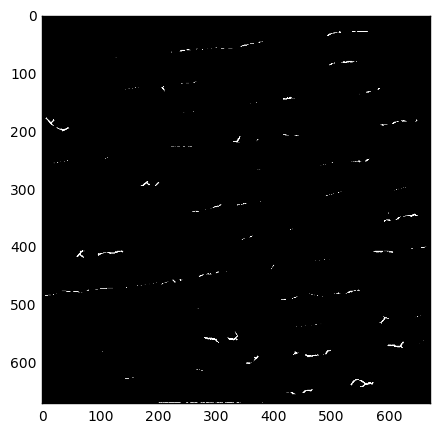

In [45]:
dilated_2 = dilated.copy()

for c in contours:
    # find bounding box coordinates
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(imgobj, (x,y), (x+w, y+h), (0, 255, 0), 2)
    
   
        
    # find minimum area
    rect = cv2.minAreaRect(c)
    # calculate coordinates of the minimum area rectangle
    box = cv2.boxPoints(rect)
    # normalize coordinates to integers
    box = np.int0(box)
    # draw contours
    cv2.drawContours(dilated_2, [box], 0, (0,0, 255), 3)
    # calculate center and radius of minimum enclosing circle
    #(x,y),radius = cv2.minEnclosingCircle(c)
    # cast to integers
    #center = (int(x),int(y))
    #radius = int(radius)
    # draw the circle
    #imgcc = cv2.circle(img_read,center,radius,(0,255,0),2)
    #cv2.drawContours(imgcc, contours, -1, (255, 0, 0), 1)
    
plt.figure(figsize=(5, 5))
plt.imshow(dilated_2,cmap=plt.get_cmap('gray'))
plt.show()


In [46]:
from skimage import io
import scipy
from skimage import morphology

In [47]:

cnt = contours[0]
print(cnt)

cv2.drawContours(skel,[cnt],0,(255,0,0),1)


[[[190 668]]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

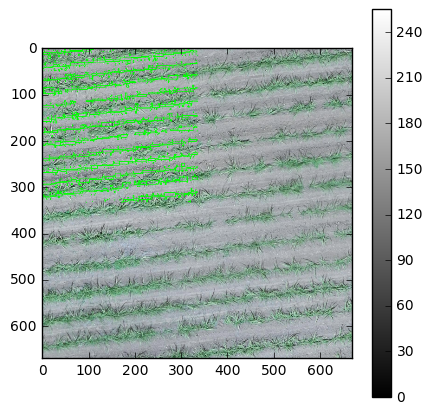

In [48]:
quarter2 = cv2.resize(imgobj, (0,0), fx=0.5, fy=0.5)

plt.figure(figsize=(5, 5))
plt.imshow(quarter2,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()